## INTRODUCTION.

This Notebook has the process of Identifying mental health risk and its severance.

We use the distribution data.csv with the columns 'Age', 'Gender', 'Occupation', 'Mental_Health_Condition', 'Severity',
       'Consultation_History', 'Stress_Level', 'Sleep_Hours', 'Work_Hours',
       'Physical_Activity_Hours', 'Social_Media_Usage', 'Diet_Quality',
       'Smoking_Habit', 'Alcohol_Consumption', 'Medication_Usage' to train a stacked catboost, LGBM and Logistic model.
       
For the output, a user inputs the features Age', 'Gender', 'Occupation','Consultation_History', 'Stress_Level', 'Sleep_Hours', 'Work_Hours',
       'Physical_Activity_Hours', 'Social_Media_Usage', 'Diet_Quality',
       'Smoking_Habit', 'Alcohol_Consumption', 'Medication_Usage' and the model predicts the risk of gaining a disorder and the severance of the disorder.

## IMPORTING NECESSARY LIBRARIES

In [ ]:
# !pip install catboost
# !pip install lightgbm

In [ ]:
# !pip install imblearn

In [3]:
#Install Necessary Libraries.
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [4]:
#Load the data
data = pd.read_csv("distribution_data.csv")
data = data.drop(["User_ID","Country"], axis =1)

In [5]:
print(f"The data has: {data.shape[0]} rows and {data.shape[1]} columns")
print(f"The data has the followinc columns: {data.columns}")

The data has: 50000 rows and 15 columns
The data has the followinc columns: Index(['Age', 'Gender', 'Occupation', 'Mental_Health_Condition', 'Severity',
       'Consultation_History', 'Stress_Level', 'Sleep_Hours', 'Work_Hours',
       'Physical_Activity_Hours', 'Social_Media_Usage', 'Diet_Quality',
       'Smoking_Habit', 'Alcohol_Consumption', 'Medication_Usage'],
      dtype='object')


## Exploratory Data Analysis (EDA).

### Cleaning the data

In [6]:
#Get the number of blank rows.
print(data.isnull().sum())

Age                            0
Gender                         0
Occupation                     0
Mental_Health_Condition        0
Severity                   25002
Consultation_History           0
Stress_Level                   0
Sleep_Hours                    0
Work_Hours                     0
Physical_Activity_Hours        0
Social_Media_Usage             0
Diet_Quality                   0
Smoking_Habit                  0
Alcohol_Consumption            0
Medication_Usage               0
dtype: int64


In [7]:
#Fill the Missing Data in Severity column with the mode.
data['Severity'].fillna(data['Severity'].mode()[0], inplace=True)

print(data.isnull().sum())

Age                        0
Gender                     0
Occupation                 0
Mental_Health_Condition    0
Severity                   0
Consultation_History       0
Stress_Level               0
Sleep_Hours                0
Work_Hours                 0
Physical_Activity_Hours    0
Social_Media_Usage         0
Diet_Quality               0
Smoking_Habit              0
Alcohol_Consumption        0
Medication_Usage           0
dtype: int64


C:\Users\Chege Waweru\AppData\Local\Temp\ipykernel_10324\430267451.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Severity'].fillna(data['Severity'].mode()[0], inplace=True)


### Data Analysis

Mental_Health_Condition    No   Yes
Gender                             
Female                   6303  6330
Male                     6273  6200
Non-binary               6093  6243
Prefer not to say        6334  6224


Text(0, 0.5, 'Count')

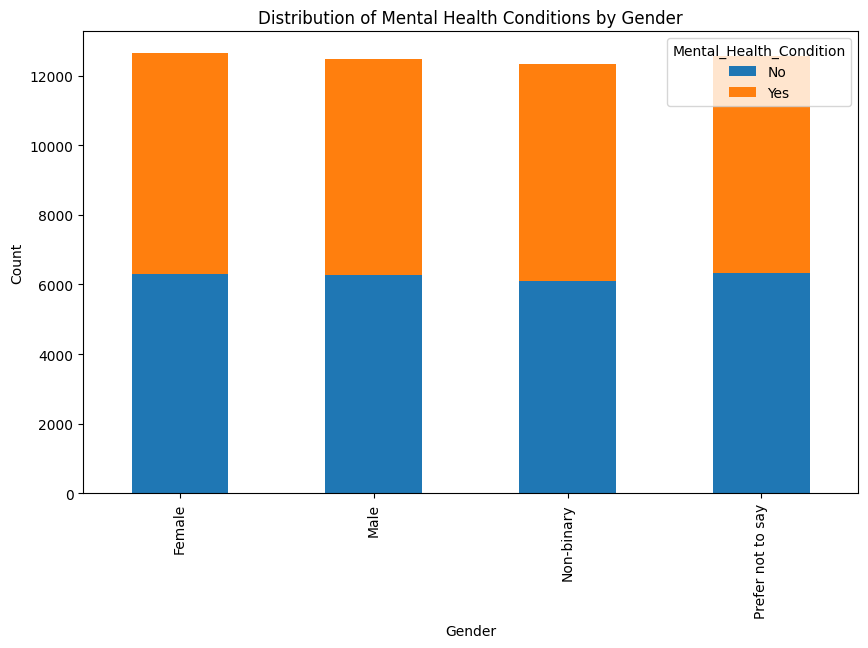

In [8]:
#Get the distribution of Mental Health conditions with respect to gender.
gender_condition_distribution = data.groupby(['Gender', 'Mental_Health_Condition']).size().unstack(fill_value=0)
print(gender_condition_distribution)

#Plot the distribution.
gender_condition_distribution.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribution of Mental Health Conditions by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')

As shown above the data is balanced as the number of those with mental health conditions is almost same to those without across different genders.

Occupation
Finance        3693
Education      3630
IT             3614
Healthcare     3555
Engineering    3530
Other          3488
Sales          3487
Name: count, dtype: int64


Text(0, 0.5, 'Count')

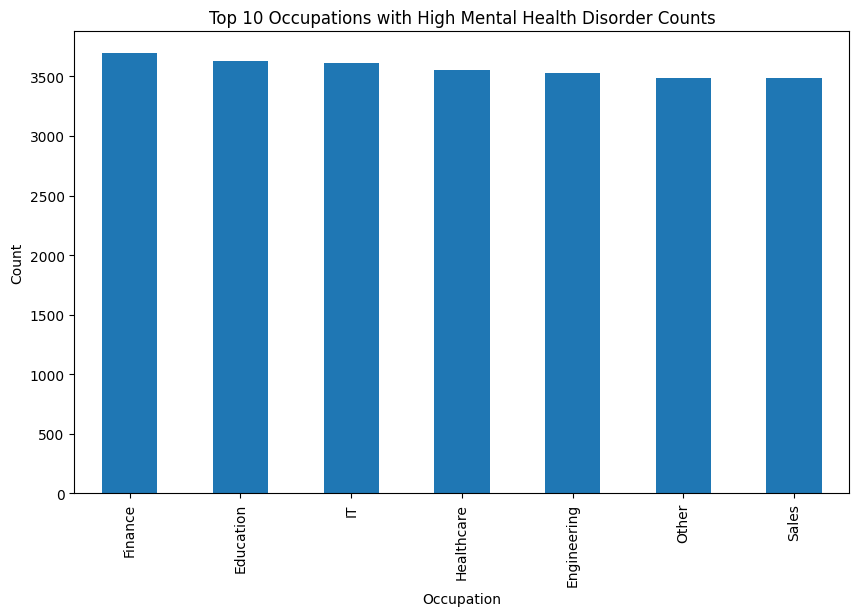

In [9]:
#Find the top 10 occcupations with high mental health disorder counts.
top_10_occupations = data[data['Mental_Health_Condition'] == 'Yes']['Occupation'].value_counts().head(10)
print(top_10_occupations)

#Plot the top ten.
plt.figure(figsize=(10, 6))
top_10_occupations.plot(kind='bar')
plt.title('Top 10 Occupations with High Mental Health Disorder Counts')
plt.xlabel('Occupation')
plt.ylabel('Count')

As shown above the Finance occupation has the highest counts of mental health cases with 3693 cases followed by Education with 3630 cases and IT with 3614 cases

Mental_Health_Condition    No   Yes
Alcohol_Consumption                
Heavy Drinker            6217  6257
Non-Drinker              6320  6187
Regular Drinker          6263  6268
Social Drinker           6203  6285


Text(0, 0.5, 'Count')

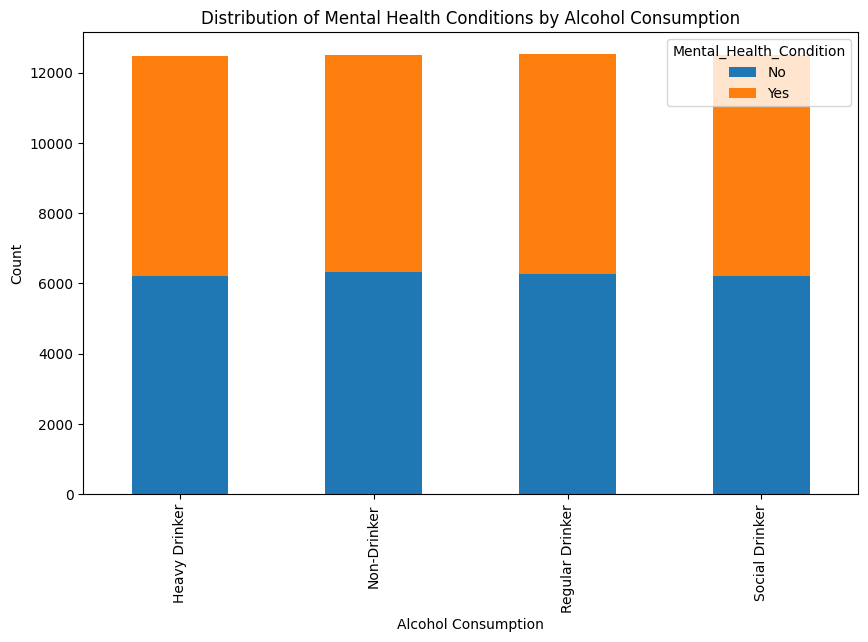

In [10]:
#Find the relationship between alcohol usage with mental health.
alcohol_condition_distribution = data.groupby(['Alcohol_Consumption', 'Mental_Health_Condition']).size().unstack(fill_value=0)
print(alcohol_condition_distribution)

#Plot the distribution.
alcohol_condition_distribution.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribution of Mental Health Conditions by Alcohol Consumption')
plt.xlabel('Alcohol Consumption')
plt.ylabel('Count')

According to the data as shown above, for all the alcohol classes the alcohol users had higher counts of mental disorders than the non-users.

Mental_Health_Condition    No   Yes
Smoking_Habit                      
Heavy Smoker             6114  6312
Non-Smoker               6322  6258
Occasional Smoker        6307  6249
Regular Smoker           6260  6178


Text(0, 0.5, 'Count')

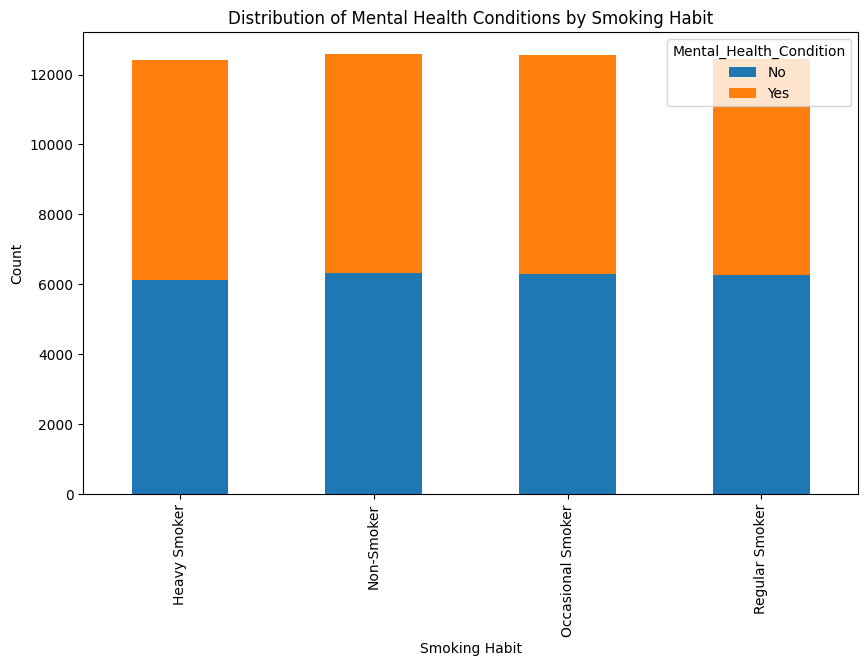

In [11]:
#Find the relationship of smokers and mental health disorders.
smoker_condition_distribution = data.groupby(['Smoking_Habit', 'Mental_Health_Condition']).size().unstack(fill_value=0)
print(smoker_condition_distribution)

#Plot the distribution.
smoker_condition_distribution.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribution of Mental Health Conditions by Smoking Habit')
plt.xlabel('Smoking Habit')
plt.ylabel('Count')

As shown above, for the heavy smokers, there was a higher count for those with mental health disorders than those without.

For the other classes there were less no disorder counts than the disorder positive counts.

## MODELLING.

### Prepare the data further.

In [12]:
#Create a combined index.

data["Work_Sleep_Ratio"] = data["Work_Hours"] / (data["Sleep_Hours"] + 1)  # avoid divide by zero
data["Activity_Sleep_Balance"] = data["Physical_Activity_Hours"] / (data["Sleep_Hours"] + 1)

# Define custom mappings
stress_map = {"Low": 0, "Medium": 1, "High": 2}
diet_map = {"Healthy": 0, "Average": 1, "Unhealthy": 2}
alcohol_map = {"Non-Drinker": 0, "Social Drinker": 1, "Regular Drinker": 2, "Heavy Drinker": 3}
smoke_map = {"Non-Smoker": 0, "Occasional Smoker": 1, "Regular Smoker": 2, "Heavy Smoker": 3}

# Apply mappings
data["Stress_Score"] = data["Stress_Level"].map(stress_map)
data["Diet_Score"] = data["Diet_Quality"].map(diet_map)
data["Alcohol_Score"] = data["Alcohol_Consumption"].map(alcohol_map)
data["Smoke_Score"] = data["Smoking_Habit"].map(smoke_map)

# Total Risk Score
data["Lifestyle_Risk_Score"] = data["Stress_Score"] + data["Diet_Score"] + data["Alcohol_Score"] + data["Smoke_Score"]
data["Final_Risk_Index"] = data["Lifestyle_Risk_Score"] + data["Work_Sleep_Ratio"] + data["Activity_Sleep_Balance"]


### Encoding.

In [13]:
# Initialize dictionary to store encoders
encoders = {}

# Encode categorical columns and save each encoder
categorical_cols = ['Gender', 'Occupation', 'Diet_Quality', 'Smoking_Habit', 'Alcohol_Consumption', 'Stress_Level','Consultation_History','Medication_Usage']
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    encoders[col] = le

In [14]:
#Define X and y
features = [
    'Age',
    'Gender',
    'Occupation',
    'Diet_Quality',
    'Smoking_Habit',
    'Alcohol_Consumption',
    'Sleep_Hours',
    'Physical_Activity_Hours',
    'Stress_Level',
    'Social_Media_Usage',
    'Consultation_History',
    'Medication_Usage',
    'Work_Hours'
]

X = data[features]
y_Class = data['Mental_Health_Condition']

y_severity= data['Severity']
sev_encoder = LabelEncoder()
y_severity_enc = sev_encoder.fit_transform(y_severity)


print(X.head())
print(type(X))

   Age  Gender  Occupation  Diet_Quality  Smoking_Habit  Alcohol_Consumption  \
0   36       1           0             1              3                    2   
1   48       1           1             2              0                    3   
2   18       3           6             1              0                    3   
3   30       2           1             0              3                    2   
4   58       1           4             2              3                    1   

   Sleep_Hours  Physical_Activity_Hours  Stress_Level  Social_Media_Usage  \
0          7.6                        8             1                 2.2   
1          6.8                        2             1                 3.4   
2          7.1                        9             2                 5.9   
3          6.9                        4             1                 5.4   
4          4.7                       10             0                 3.3   

   Consultation_History  Medication_Usage  Work_Hours  


In [15]:
print("Available encoders:", list(encoders.keys()))

Available encoders: ['Gender', 'Occupation', 'Diet_Quality', 'Smoking_Habit', 'Alcohol_Consumption', 'Stress_Level', 'Consultation_History', 'Medication_Usage']


In [16]:
#Split the data.
X_train_Class, X_test_Class, y_train_Class, y_test_Class = train_test_split(X, y_Class, test_size=0.2, random_state=42)
X_train_severity, X_test_severity, y_train_severity, y_test_severity = train_test_split(X, y_severity_enc, test_size=0.2, random_state=42)
print(type(X_train_Class))
print(type(X_train_severity))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [17]:
#Model Parameters for tuning.
catboost_params = {
    'iterations': [100, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}

lgbm_params = {
    'n_estimators': [100, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [15, 31, 63],
    'min_child_samples': [10, 20]
}

lr_params = {
    'C': [0.1, 1.0, 10],
    'solver': ['liblinear', 'lbfgs']
}


In [18]:
#Catboost tuning
#Classifier.
cat_Class = CatBoostClassifier(verbose=0, random_state=42)
cat_search_Class = RandomizedSearchCV(cat_Class, catboost_params, cv=3, scoring='accuracy', n_iter=10, random_state=42)
cat_search_Class.fit(X_train_Class, y_train_Class)

best_cat_Class = cat_search_Class.best_estimator_

#Severity.
cat_sev = CatBoostClassifier(verbose=0, random_state=42)
cat_search_sev = RandomizedSearchCV(cat_sev, catboost_params, cv=3, scoring='accuracy', n_iter=10, random_state=42)
cat_search_sev.fit(X_train_severity, y_train_severity)

best_cat_sev = cat_search_sev.best_estimator_

In [19]:
#LGBM tuning
#Classifier
lgb_Class = LGBMClassifier(random_state=42)
lgb_search_Class = RandomizedSearchCV(lgb_Class, lgbm_params, cv=3, scoring='accuracy', n_iter=10, random_state=42)
lgb_search_Class.fit(X_train_Class, y_train_Class)

best_lgb_Class = lgb_search_Class.best_estimator_

#Severity
lgb_sev = LGBMClassifier(random_state=42)
lgb_search_sev = RandomizedSearchCV(lgb_sev, lgbm_params, cv=3, scoring='accuracy', n_iter=10, random_state=42)
lgb_search_sev.fit(X_train_severity, y_train_severity)

best_lgb_sev = lgb_search_sev.best_estimator_

[LightGBM] [Info] Number of positive: 13336, number of negative: 13330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 26666, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500113 -> initscore=0.000450
[LightGBM] [Info] Start training from score 0.000450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [20]:
#Logistic regression tuning
#Classifier
lr_Class = LogisticRegression(max_iter=1000)
lr_search_Class = RandomizedSearchCV(lr_Class, lr_params, cv=3, scoring='accuracy', n_iter=5, random_state=42)
lr_search_Class.fit(X_train_Class, y_train_Class)

best_lr_Class = lr_search_Class.best_estimator_

#Severity
lr_sev = LogisticRegression(max_iter=1000)
lr_search_sev = RandomizedSearchCV(lr_sev, lr_params, cv=3, scoring='accuracy', n_iter=5, random_state=42)
lr_search_sev.fit(X_train_severity, y_train_severity)

best_lr_sev = lr_search_sev.best_estimator_

In [21]:
# Base learners

base_learners = [
    ('catboost', CatBoostClassifier(verbose=0, random_state=42)),
    ('lightgbm', LGBMClassifier(random_state=42))
]

# Meta-learner: Logistic Regression
meta_learner = LogisticRegression()

# Stacking Classifier
stack_model_Class = StackingClassifier(
    estimators=[
        ('catboost', best_cat_Class),
        ('lightgbm', best_lgb_Class)
    ],
    final_estimator=best_lr_Class,
    passthrough=True,
    cv=5
)

#Stacking Severity.
stack_model_sev = StackingClassifier(
    estimators=[
        ('catboost', best_cat_sev),
        ('lightgbm', best_lgb_sev)
    ],
    final_estimator=best_lr_sev,
    passthrough=True,
    cv=5
)


### Fit the Model

In [22]:
#Fit Classifier
stack_model_Class.fit(X_train_Class, y_train_Class)
y_pred_Class = stack_model_Class.predict(X_test_Class)

# Evaluation
print(" Accuracy:", accuracy_score(y_test_Class, y_pred_Class))
print(classification_report(y_test_Class, y_pred_Class))


#Fit Severity.
stack_model_sev.fit(X_train_severity, y_train_severity)
y_pred_sev = stack_model_sev.predict(X_test_severity)

# Evaluation
print(" Accuracy:", accuracy_score(y_test_severity, y_pred_sev))
print(classification_report(y_test_severity, y_pred_sev))


[LightGBM] [Info] Number of positive: 20004, number of negative: 19996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500100 -> initscore=0.000400
[LightGBM] [Info] Start training from score 0.000400
[LightGBM] [Info] Number of positive: 16004, number of negative: 15996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 13
[LightGBM] [Info] [bin

c:\Users\Chege Waweru\Desktop\p6\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Chege Waweru\Desktop\p6\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Chege Waweru\Desktop\p6\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Define the function to predict mental health risk and severity

In [23]:
#Define the function to predict mental health risk and severity based on user inputs.
def get_user_inputs_and_predict():
    print("*** Mental Health Risk & Severity Predictor\n")

    # Input collection
    try:
        age = int(input("Enter your Age (e.g., 24): "))
        gender = input("Enter Gender (Male/Female/Other): ").strip()
        occupation = input("Enter Occupation (e.g., IT, Education, Sales): ").strip()
        diet_quality = input("Diet Quality (Healthy/Average/Unhealthy): ").strip()
        smoking = input("Smoking Habit (Non-Smoker/Occasional Smoker/Regular Smoker/Heavy Smoker): ").strip()
        alcohol = input("Alcohol Consumption (Non-Drinker/Social Drinker/Regular Drinker/Heavy Drinker): ").strip()
        sleep_hours = float(input("Sleep Hours (e.g., 7.5): "))
        physical_activity = float(input("Physical Activity Hours per day (e.g., 1.5): "))
        stress_level = input("Stress Level (Low/Medium/High): ").strip()
        social_media_hours = float(input("Social Media Usage Hours (e.g., 4): "))
        consultation_history = input("Consultation History (Yes/No): ").strip()
        medication = input("Medication Usage (Yes/No): ").strip()
        work_hours = float(input("Work Hours (e.g., 8): "))

        # Create DataFrame for prediction
        sample = pd.DataFrame([{
            'Age': age,
            'Gender': encoders['Gender'].transform([gender])[0],
            'Occupation': encoders['Occupation'].transform([occupation])[0],
            'Consultation_History': encoders['Consultation_History'].transform([consultation_history])[0],
            'Stress_Level': stress_map[stress_level],
            'Sleep_Hours': sleep_hours,
            'Work_Hours': work_hours,
            'Physical_Activity_Hours': physical_activity,
            'Social_Media_Usage': social_media_hours,
            'Diet_Quality': diet_map[diet_quality],
            'Smoking_Habit': smoke_map[smoking],
            'Alcohol_Consumption': alcohol_map[alcohol],
            'Medication_Usage': encoders['Medication_Usage'].transform([medication])[0]
        }])

        # Predictions
        risk_pred = stack_model_Class.predict(sample)[0]
        risk_label = "Yes" if risk_pred == 1 else "No"

        print("\n** Prediction Results:")
        print("* Mental Health Risk:", risk_label)

        if risk_label == "Yes":
            severity_pred = stack_model_sev.predict(sample)[0]
            print("* Severity Level:", severity_pred)
        else:
            print("* No disorder detected at this time. Keep maintaining healthy habits.")

    except Exception as e:
        print("** Input Error:", e)


### Save the Model

In [24]:
# Save the model and encoders
structured_bundle = {
    "risk_model": stack_model_Class,
    "severity_model": stack_model_sev,
    "encoders": encoders,  # LabelEncoders or dicts for Gender, Diet, etc.
}

with open("model_structured.pkl", "wb") as f:
    pickle.dump(structured_bundle, f)
